# Прогнозирование уровня загрязнения воздуха

## 1. Постановка задачи

**Загрязнение воздуха** — один из ключевых факторов, негативно влияющих на здоровье населения и экологическую ситуацию в городах. По данным ВОЗ, загрязнённый воздух ежегодно приводит к миллионам преждевременных смертей, увеличивает нагрузку на систему здравоохранения и снижает качество жизни. Однако, традиционные методы мониторинга загрязнения требуют значительных ресурсов, а их данные часто запаздывают.

**Цель проекта** — создать модель для прогноза уровня загрязнения воздуха на основании исторических данных об измерениях ключевых загрязняющих веществ.

Для обучения модели мы будем использовать данные о качестве воздуха в разных городах Индии, включая концентрации различных загрязняющих веществ и индекс качества воздуха (AQI).

**AQI** (индекс качества воздуха) используется для оценки уровня загрязнения атмосферы. Он показывает, насколько чист или загрязнён воздух, и как это может повлиять на здоровье человека. Рассчитывается AQI на основании измерений PM2.5, PM10, NO2, SO2, CO, O3.

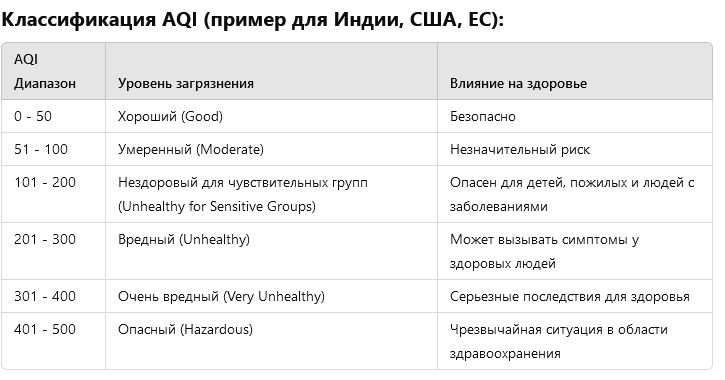

# 2. Разведывательный анализ данных (EDA)

Приступим к анализу данных.

In [ ]:
# загружаем файл с гугл диска
!pip install --upgrade gdown
!gdown --id 1Wbz4eporROAL7ybjID1FNwnOveR3mwMB

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Wbz4eporROAL7ybjID1FNwnOveR3mwMB
To: /content/city_day.csv
100% 2.57M/2.57M [00:00<00:00, 161MB/s]


In [ ]:
import pandas as pd

# прочитаем данные и проведем обзор таблицы
df = pd.read_csv('city_day.csv')
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
# выведем информацию о датасете
print('Размер датасета:', df.shape, '\n')
df.info()

Размер датасета: (29531, 16) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


Обзор датасета показал, что в нем есть пропущенные значения. Распределение значений данных по мониторингу воздуха, как правило, асимметрично и содержит выбросы (например, во время смога или пожаров уровень PM2.5 может резко увеличиваться). Поэтому для заполнения пропусков мы будем использовать медианные значения. Для большей точности мы будем заполнять пропуски медианой в разрезе городов, так как от города к городу экологическая обстановка может изменяться.

Также мы видим, что у колонки с датой тип object, для дальнейшего анализа необходимо будет преобразовать тип данных в datetime.

Следующим шагом мы рассчитаем процент пропущенных числовых значений по каждому городу, чтобы оценить полноту данных.

In [ ]:
# выбираем только числовые столбцы
numeric_cols = df.select_dtypes(include=['number']).columns

# посчитаем процент NaN для каждого признака в разрезе городов
missing_per_feature = df.groupby('City')[numeric_cols].apply(lambda x: x.isnull().sum() / len(x) * 100).round(2)
print(missing_per_feature)

                    PM2.5    PM10     NO    NO2     NOx     NH3     CO    SO2  \
City                                                                            
Ahmedabad           31.26   79.74  30.31  30.26   29.57  100.00  30.31  31.86   
Aizawl               1.77    0.88   0.00   0.00    0.00    0.00   0.00   0.00   
Amaravati            6.20    5.78   5.78   5.78    5.78    5.78  10.20   6.83   
Amritsar            10.48    5.16   7.62   3.60   23.67    3.44   6.22  13.76   
Bengaluru            7.27   17.92   0.30   0.30    0.20   10.10   0.55   0.30   
Bhopal               3.11    3.11   3.11   3.11    3.11    3.11   3.11   3.11   
Brajrajnagar        19.72   18.44  25.91  24.95   18.66   24.09  15.99  20.58   
Chandigarh           4.93    0.00   1.32   1.32    1.32    3.29   0.00   0.00   
Chennai              5.82   84.97   1.79   1.79    1.79   23.00   1.24   1.79   
Coimbatore           2.07    1.81  14.25   2.85    1.04   31.87   0.78   0.78   
Delhi                0.10   

Мы видим достаточное количество пропусков. Приступим к их заполнению.

In [ ]:
from datetime import datetime

# преобразуем столбец с датами к типу данных datetime
df['Date'] = pd.to_datetime(df['Date'])

# все числовые признаки, кроме AQI
columns_to_fill = numeric_cols[:-1]

# заполняем NaN в числовых столбцах медианой по городу
df[columns_to_fill] = df.groupby('City')[columns_to_fill].transform(lambda x: x.fillna(x.median())).round(2)

# заполняем оставшиеся пропуски медианой по признаку
df[columns_to_fill] = df[columns_to_fill].transform(lambda x: x.fillna(x.median())).round(2)

# проверяем, есть ли еще пропущенные значения
print(df.isnull().sum())

City             0
Date             0
PM2.5            0
PM10             0
NO               0
NO2              0
NOx              0
NH3              0
CO               0
SO2              0
O3               0
Benzene          0
Toluene          0
Xylene           0
AQI           4681
AQI_Bucket    4681
dtype: int64


Так как доля пропусков признака AQI значительна, этот показатель критичен для модели и необходима высокая точность, мы заполним пропущенные значения спрогнозированными данными.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# столбец с пропусками
missing_col = 'AQI'
# признаки
features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
# группировка по городам
group_col = 'City'

# проходим по каждой группе
for city, city_df in df.groupby(group_col):
    train_df = city_df[city_df[missing_col].notna()]
    test_df = city_df[city_df[missing_col].isna()]

    # пропускаем, если нет данных для обучения или предсказания
    if train_df.empty or test_df.empty:
        continue

    X_train, y_train = train_df[features], train_df[missing_col]
    X_test = test_df[features]

    # обучаем модель
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # заполняем пропущенные значения предсказанными
    df.loc[(df[group_col] == city) & (df[missing_col].isna()), missing_col] = model.predict(X_test).round(2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        29531 non-null  object        
 1   Date        29531 non-null  datetime64[ns]
 2   PM2.5       29531 non-null  float64       
 3   PM10        29531 non-null  float64       
 4   NO          29531 non-null  float64       
 5   NO2         29531 non-null  float64       
 6   NOx         29531 non-null  float64       
 7   NH3         29531 non-null  float64       
 8   CO          29531 non-null  float64       
 9   SO2         29531 non-null  float64       
 10  O3          29531 non-null  float64       
 11  Benzene     29531 non-null  float64       
 12  Toluene     29531 non-null  float64       
 13  Xylene      29531 non-null  float64       
 14  AQI         29531 non-null  float64       
 15  AQI_Bucket  24850 non-null  object        
dtypes: datetime64[ns](1), 

Все числовые данные заполнены. Рассмотрим значения показателя AQI подробнее.

In [ ]:
df['AQI'].describe()

,AQI
count,29531.000000
mean,162.834313
std,132.559948
min,13.000000
25%,85.000000
50%,123.000000
75%,190.000000
max,2049.000000


Мы видим большой разброс между min и max значениями. Среднее значение отличается от медианного, что может означать наличие выбросов. Рассчитаем 90-процентиль:

In [ ]:
percentile_90 = df['AQI'].quantile(0.9)
print('90-процентиль:', percentile_90)

90-процентиль: 328.0


Большая разница между 90-процентилем и максимальным значением признака более явно указывает на наличие выбросов. Выбросы мы не удаляем, так как это реальные значения измерений.

Построим гистограмму с кривой плотности (KDE), чтобы увидеть распределение значений индекса качества воздуха.

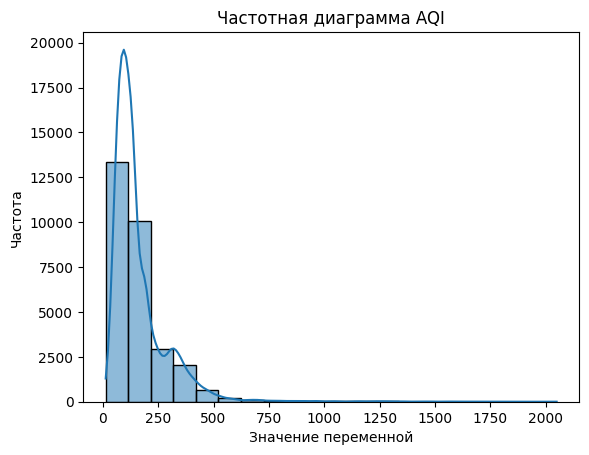

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# строим гистограмму с KDE
sns.histplot(df['AQI'], bins=20, kde=True)

plt.xlabel('Значение переменной')
plt.ylabel('Частота')
plt.title('Частотная диаграмма AQI')

plt.show()

**Большая часть данных сосредоточена слева** (значения AQI от 0 до 250), что говорит о том, что большинство городов (или дней) имеют относительно чистый воздух.

Распределение данных асимметрично и имеет **положительную скошенность**, большая часть значений сосредоточена ближе к низким значениям, а редкие высокие значения образуют хвост.

Построим тепловую матрицу корреляции.

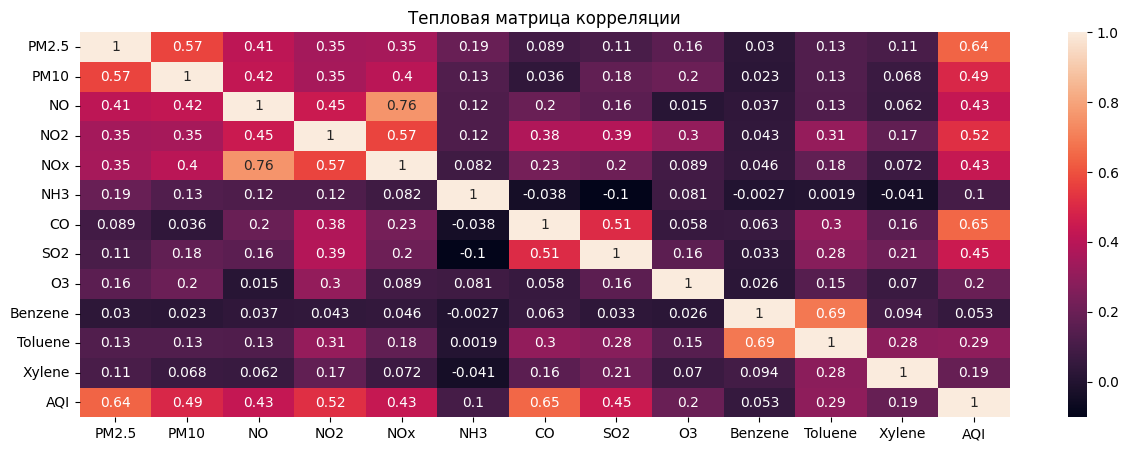

In [ ]:
# корреляция
df_num = df.copy()
df_num = df_num.drop(['City','Date','AQI_Bucket'], axis=1)
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(
    data=df_num.corr(),
    annot=True)
ax.set_title('Тепловая матрица корреляции');

Сильная корреляция между NO (оксид азота) и NOx (оксиды азота) объясняется их химическим составом и происхождением. Связь между бензином и толуолом возможна из-за их общего источника выбросов. Умеренная корреляция между PM2.5, CO и AQI объясняется тем, что данные загрязнители напрямую влияют на индекс качества воздуха.

Теперь заполним столбец AQI_Bucket для классификации уровней загрязнения.

In [ ]:
# функция для категоризации
def categorize(value):
    if value <= 50:
        return 'Хороший'
    elif 50 < value <= 100:
        return 'Умеренный'
    elif 100 < value <= 200:
        return 'Нездоровый для чувствительных групп'
    elif 200 < value <= 300:
        return 'Вредный'
    elif 300 < value <= 400:
        return 'Очень вредный'
    elif 400 < value <= 500:
        return 'Опасный'
    else:
        return 'Очень опасный'

# применяем функцию для заполнения столбца
df['AQI_Bucket'] = df['AQI'].apply(categorize)

Посмотрим на диаграмму распределения категорий качества воздуха.

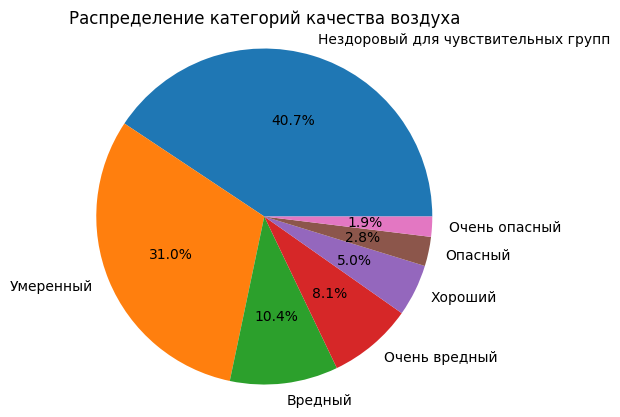

In [ ]:
# строим диаграмму
category_counts = df['AQI_Bucket'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Распределение категорий качества воздуха')

plt.show()

Большая часть измерений приходится на категорию "Нездоровый для чувствительных групп", следующая по количеству измерений категория "Умеренный". Самые близкие в процентном соотношении категории "Опасный" и "Очень опасный".

Далее диаграмма распределения AQI по городам

<ipython-input-33-e309894f1249>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_aqi.index, y=city_aqi.values, palette='viridis')


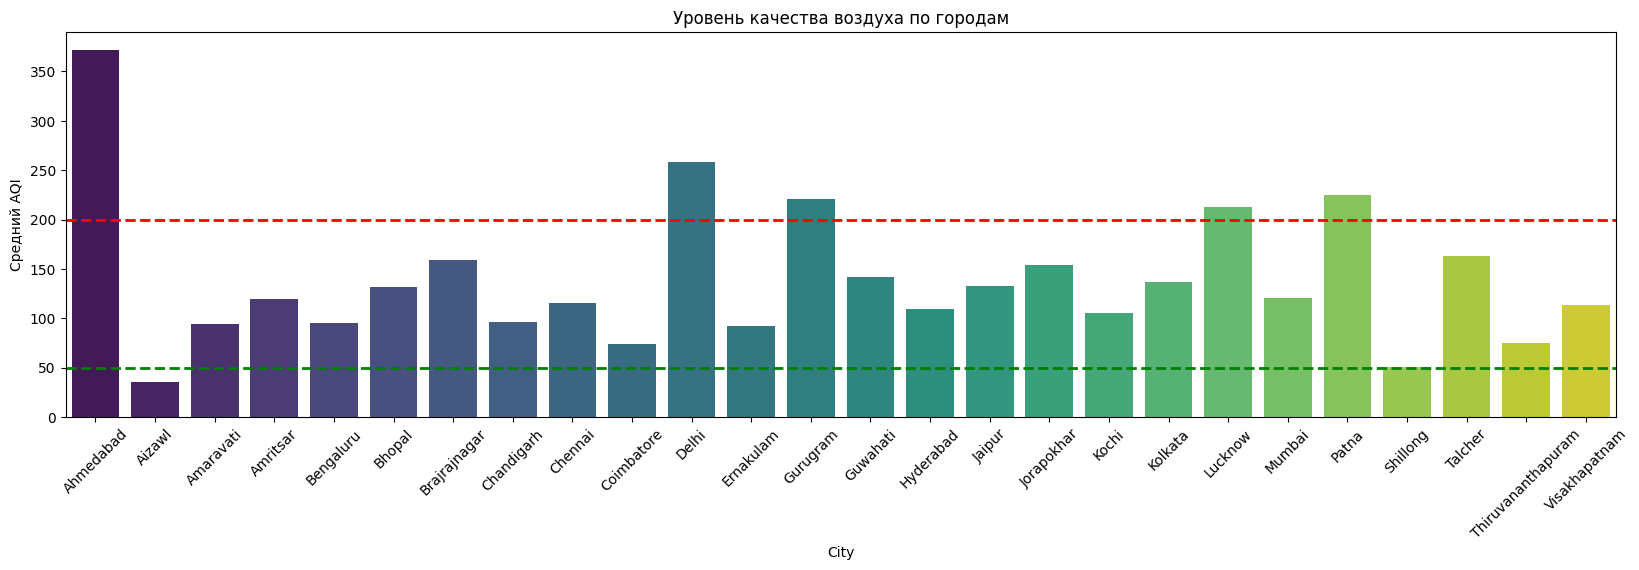

In [ ]:
# группируем данные по городам и находим среднее значение AQI
city_aqi = df.groupby('City')['AQI'].mean()
plt.figure(figsize=(20, 5))
sns.barplot(x=city_aqi.index, y=city_aqi.values, palette='viridis')

# добавляем пунктирные горизонтальные линии
plt.axhline(y=200, color='red', linestyle='--', linewidth=2)
plt.axhline(y=50, color='green', linestyle='--', linewidth=2)

# добавляем подписи
plt.title('Уровень качества воздуха по городам')
plt.ylabel('Средний AQI')
plt.tick_params(axis='x', rotation=45)

plt.show()

В большей части городов наблюдается умеренное загрязнение воздуха. Самый загрязненный воздух в городе Ахмадабад, самый чистый в городах Аиджал и Шиллонг.

Проведем графический анализ временных рядов чтобы понять, как изменялось качество воздуха с течением времени в разных городах.

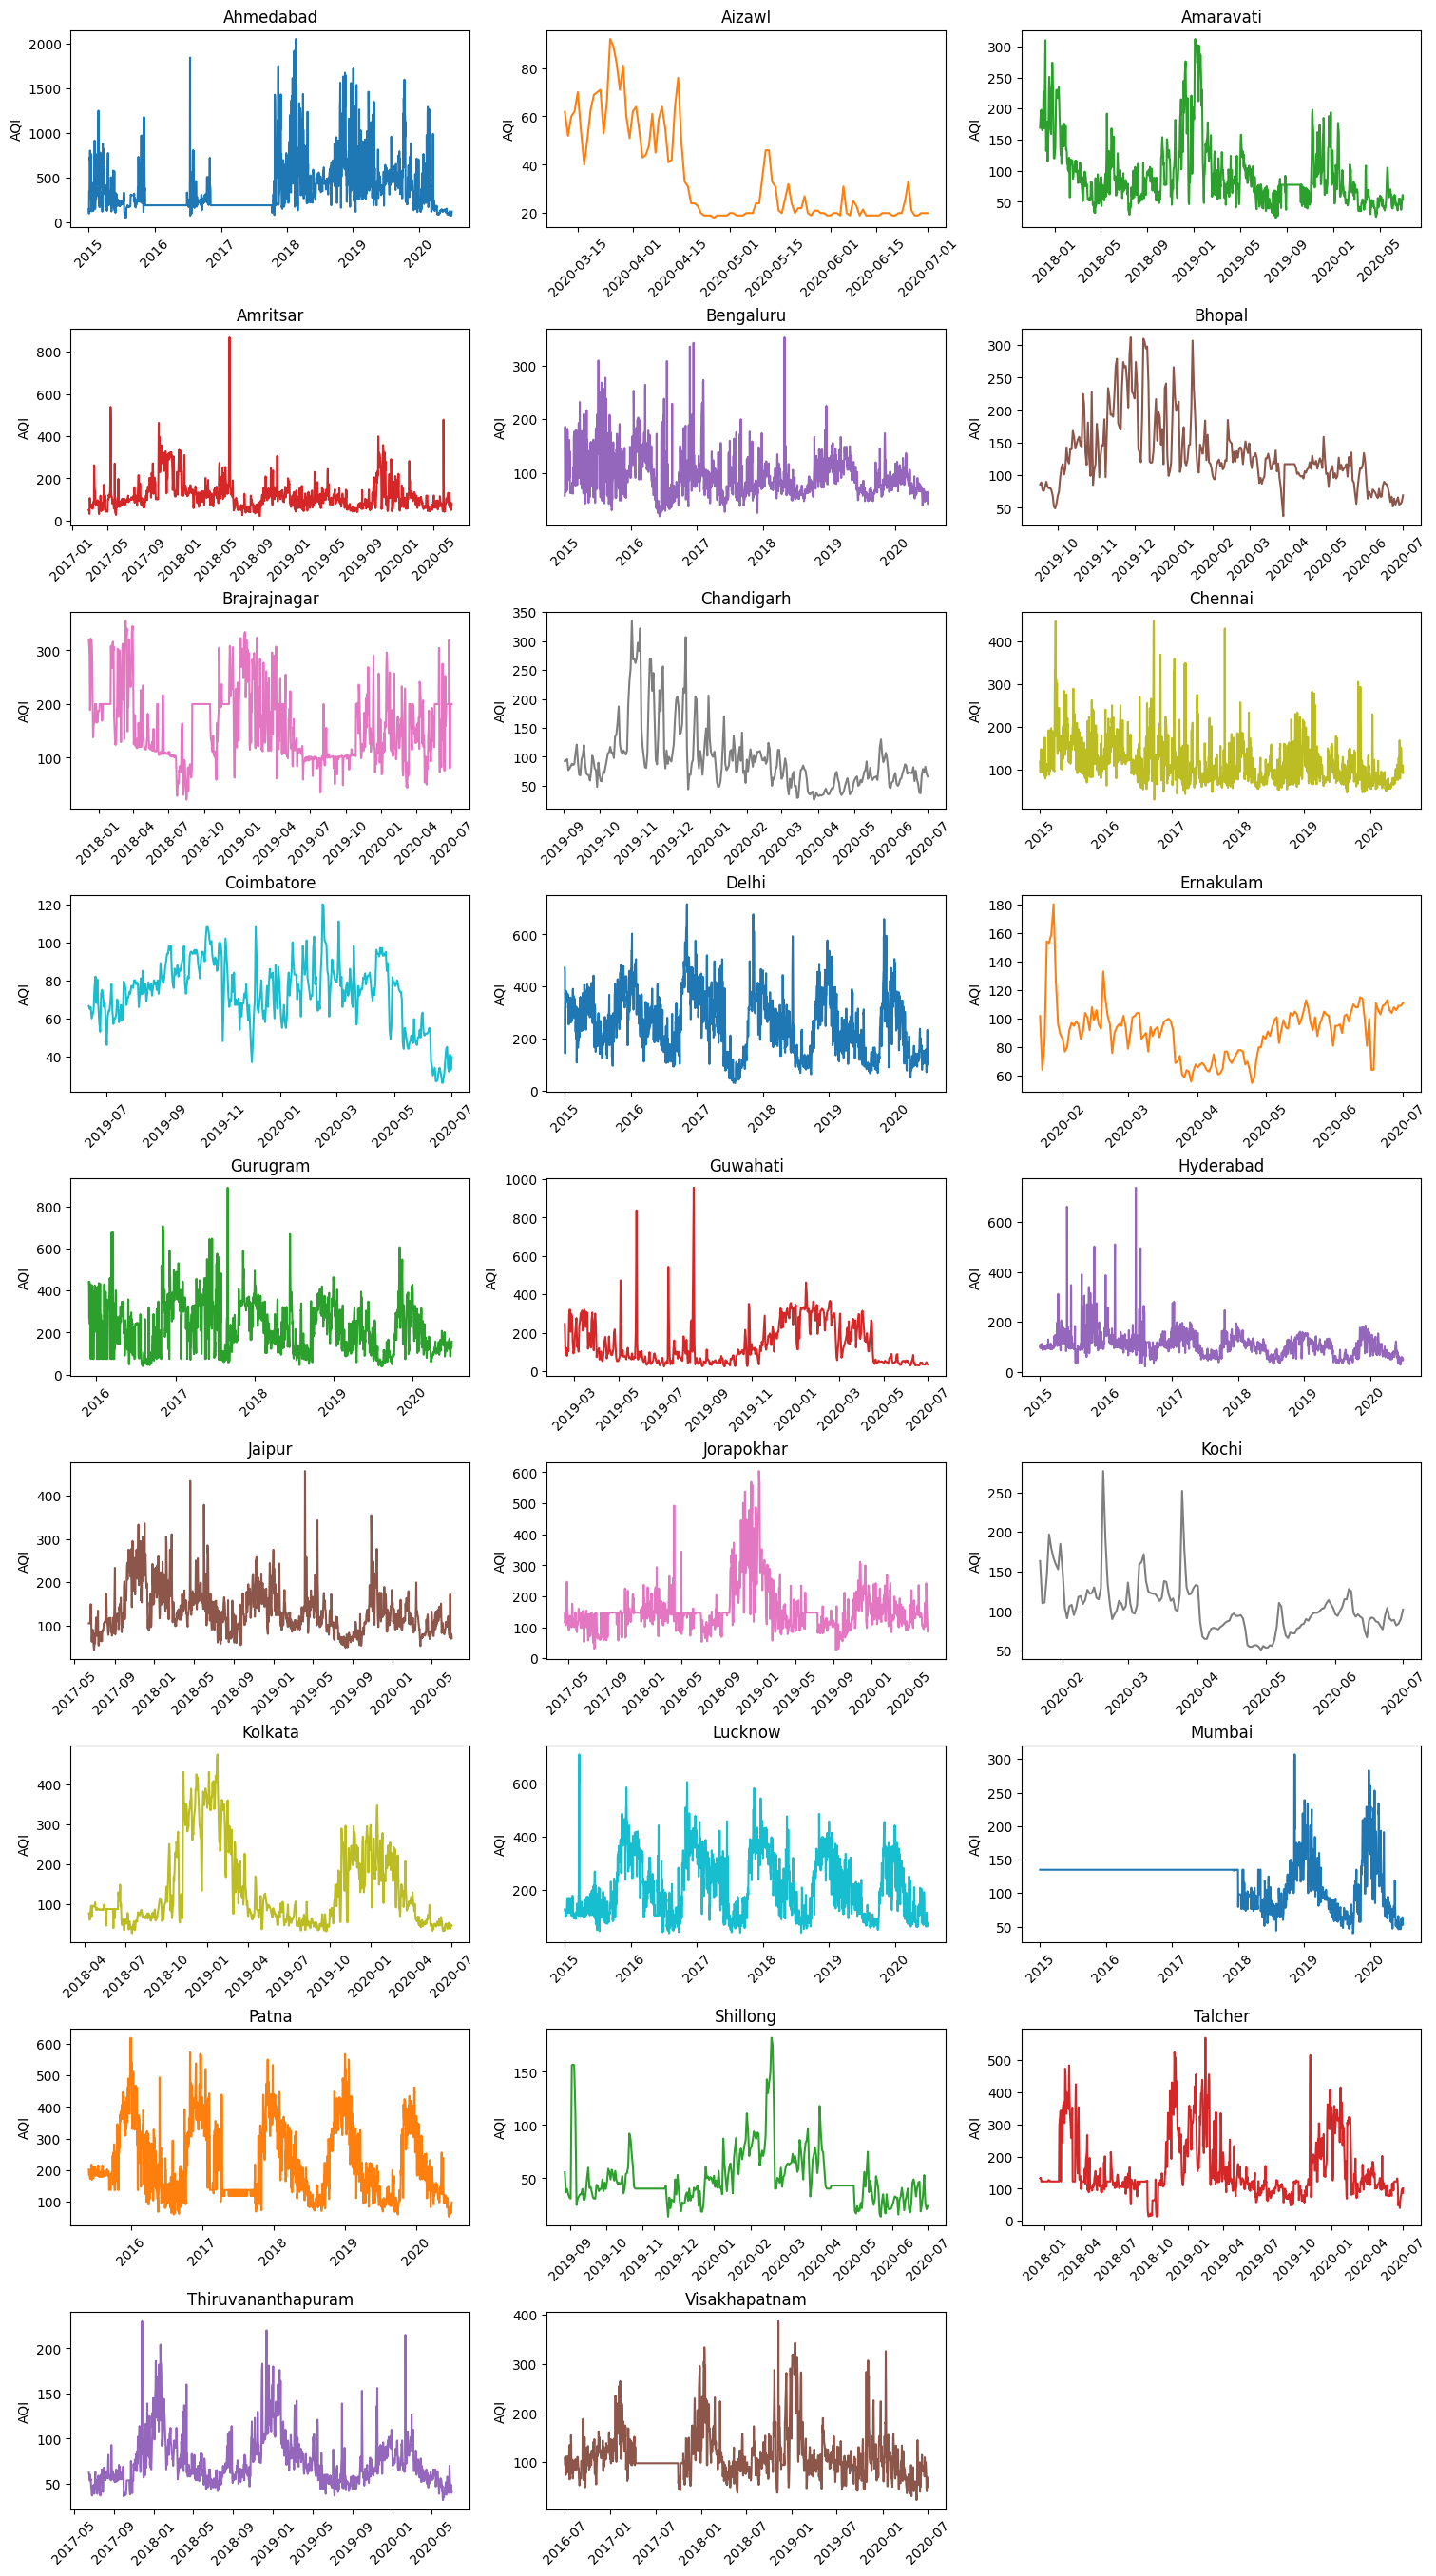

In [ ]:
import random
import math

# фильтрация уникальных городов
unique_cities = df['City'].unique()

# число графиков в строке
num_cities = len(unique_cities)

# получение палитры цветов (10 цветов)
colors = sns.color_palette('tab10', n_colors=num_cities)

# количество графиков в строке и количество строк
cols = 3
rows = math.ceil(num_cities / cols)

# создаем подграфики
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), constrained_layout=True)

# построение графиков для каждого города
for i, city in enumerate(unique_cities):
    row, col = divmod(i, cols)
    # обрабатываем случай с 1 строкой
    ax = axes[row, col] if rows > 1 else axes[col]
    city_data = df[df['City'] == city]
    ax.plot(city_data['Date'], city_data['AQI'], label=city, color=colors[i])
    ax.set_title(city)
    ax.set_ylabel('AQI')
    ax.tick_params(axis='x', rotation=45)

# удаляем лишние подграфики
for i in range(num_cities, rows * cols):
    row, col = divmod(i, cols)
    fig.delaxes(axes[row, col] if rows > 1 else axes[col])

plt.show()

На большинстве графиков явно видны **сезонные колебания**. Повышение уровня загрязнения воздуха наблюдается в зимние периоды, в летние же периоды воздух чище, что может быть связано с сезоном дождей.

Также мы видим, что не во всех городах измерения проводились в период 2015-2020 г. По городу Мумбаи данные с 2015 по 2018 год, по всей видимости, отсутствовали, и были заполнены медианным значением признака. Стоит их удалить, так как они не являются достоверными и могут негативно повлиять на точность прогнозирования.

In [ ]:
# удаляем "плохие" строки
df = df.drop(df.loc[(df['City'] == 'Mumbai') &
                    (df['Date'].between('2015-01-01', '2017-12-31'))].index)

### Выводы по EDA:

1. Данные содержали пропуски, которые были заполнены медианными значениями в разрезе городов. Пропущенные значения показателя AQI, как самого важного, были заполнены спрогнозированными данными при помощи RandomForestRegressor.
2. Сильная положительная корреляция между оксидами азота не повлияет на результаты прогнозирования, так как эти признаки не важны для построения модели.
3. Выбросы в данном случае - это нормальное свойство данных, поэтому мы будем их учитывать.
4. У показателя AQI наблюдаются сезонные колебания.

## 3. Подготовка данных

Удаляем нечисловые данные, такие как название города, чтобы избежать ошибок при вычислении корреляции и обучения модели.
Масштабирование признаков выполняется для того, чтобы все признаки имели одинаковый масштаб, что часто улучшает работу алгоритмов.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_nums = df.copy()
df_nums = df_nums.drop(['City','Date','AQI_Bucket'], axis=1)

# определяем X (признаки) и y (целевую переменную)
X = df_nums.drop(columns=['AQI'])
y = df_nums['AQI']

# разбиваем данные на обучающую и тестовую выборки (например, 80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# масштабируем числовые признаки для улучшения работы модели (опционально)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Подготовка данных завершена.')

Подготовка данных завершена.


## 4. Машинное обучение (ML)

Выбираем модель RandomForestRegressor, которая хорошо работает с табличными данными, устойчива к выбросам и не требует масштабирования признаков, однако в данном случае масштабирование всё равно помогает.
Обучение происходит на 80% данных, остальные 20% используются для тестирования модели.

In [ ]:
# инициализируем модель RandomForestRegressor с базовыми гиперпараметрами
# (при желании можно провести гиперпараметрическую оптимизацию)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# обучаем модель на обучающих данных
model.fit(X_train_scaled, y_train)

print('Обучение модели завершено.')

Обучение модели завершено.


## 5. Оценка качества модели

Вычисляем основные метрики: MSE, MAE и MAPE, чтобы сравнить с результатами.
Для более глубокого анализа построены графики:

**Анализ остатков** - распределение разницы между фактическими и предсказанными значениями помогает выявить систематические ошибки.

**Визуализация предсказаний** - диаграмма рассеяния показывает, насколько хорошо предсказания модели совпадают с фактическими значениями.
Такой подход позволяет не только оценить качество модели, но и выявить возможные направления для её улучшения.

Средняя квадратичная ошибка (MSE) на тестовой выборке: 1357.3115468132526
Средняя абсолютная ошибка (MAE) на тестовой выборке: 18.464786946965113
Средняя абсолютная процентная ошибка (MAPE) на тестовой выборке: 12.10%


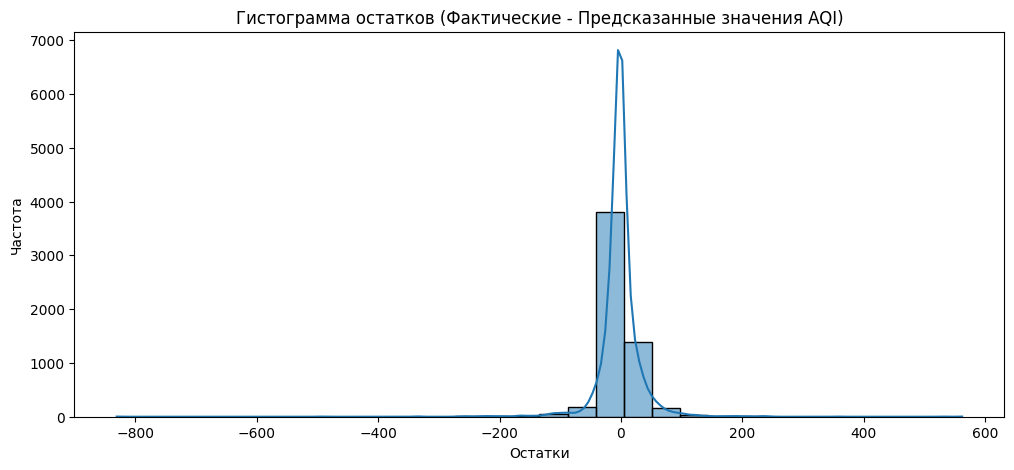

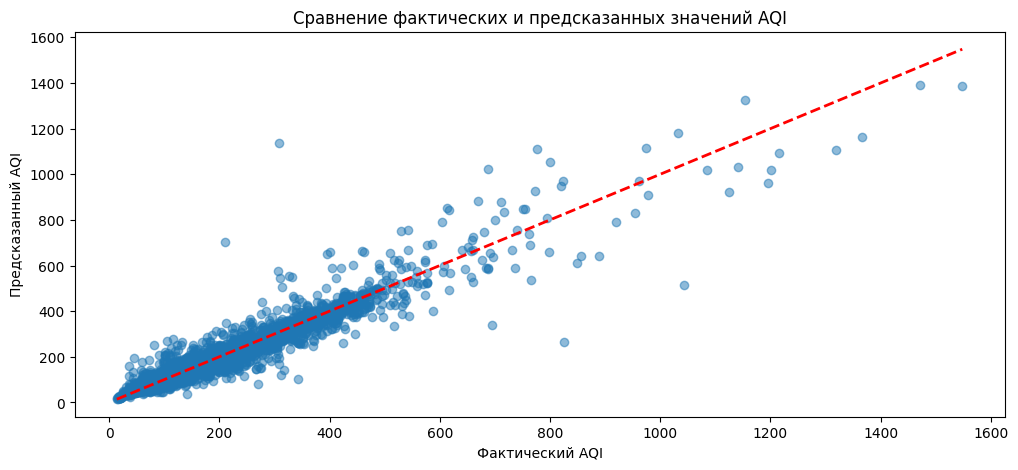

Оценка модели завершена.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# делаем предсказания на тестовой выборке
y_pred = model.predict(X_test_scaled)

# вычисляем среднюю квадратичную ошибку (MSE)
mse = mean_squared_error(y_test, y_pred)

# вычисляем среднюю абсолютную ошибку (MAE)
mae = mean_absolute_error(y_test, y_pred)

# вычисляем среднюю абсолютную процентную ошибку (MAPE)
# добавляем небольшой эпсилон, чтобы избежать деления на ноль
epsilon = 1e-10
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100

print(f'Средняя квадратичная ошибка (MSE) на тестовой выборке: {mse}')
print(f'Средняя абсолютная ошибка (MAE) на тестовой выборке: {mae}')
print(f'Средняя абсолютная процентная ошибка (MAPE) на тестовой выборке: {mape:.2f}%')

# Дополнительный анализ качества модели:
# 1. Анализ остатков

residuals = y_test - y_pred
plt.figure(figsize=(12,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Гистограмма остатков (Фактические - Предсказанные значения AQI)')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

# 2. Визуалзация предсказаний: сравнение предсказанных и фактических значений
plt.figure(figsize=(12,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактический AQI')
plt.ylabel('Предсказанный AQI')
plt.title('Сравнение фактических и предсказанных значений AQI')
plt.show()

print('Оценка модели завершена.')

## 6. Результаты

Основные выводы:
1.	Модель показала хорошие результаты в прогнозировании AQI, что может быть полезно для принятия своевременных решений по борьбе с загрязнением воздуха.
2.	Подготовка данных сыграла ключевую роль: заполнение пропусков и масштабирование признаков существенно улучшили качество модели.
3.	Нами были выявлены города с наиболее высоким уровнем загрязнения, что позволяет сосредоточить усилия на проблемных регионах.
Перспективы развития:
•	Оптимизация гиперпараметров модели для повышения точности.
•	Расширение датасета за счет данных из других стран.
•	Создание интерактивной платформы для реального времени мониторинга качества воздуха.
